Используемые технологии (эту графу делал для себя, но грейдерам тоже может быть полезна):
    * pandas 
    * API 
    * beautifulsoup
    * Регулярные выражения (использовались для правки испорченных данных)
    * numpy/scipy, SymPy
    * geopandas, shapely, folium
    * networkx
    * matplot
    * sql
    * МО
    * доп технологии
    * Документация

In [1]:
#pip install mysql-connector-python
#pip install yfinance
#pip install QuantLib
#Эти библиотеки нужно загрузить, чтобы проект работал

# Хедж фонды

### В этой работе посмотрим на мировой рынок хедж фондов и поработаем с финансовыми данными

Сначала скачаем общие данные по хедж-фондам и поанализируем - интересно узнать откуда они взялись, когда и всё в этом духе

In [2]:
#Скачаем основные библиотеки, которые будем использовать
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import mysql.connector
from mysql.connector import Error
import geopandas as gpd
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import sqlite3
import QuantLib as ql
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns

/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### DataSet №1

In [3]:
#Здесь впишите свой путь до файла
tracxn_database = pd.read_csv('/Users/Alex/Desktop/Hedge_funds_1.csv', sep=';') 
#ВАЖНО: я брал его с ресурса по корпоративной подписке, поэтому просьба не распространять его

In [4]:
tracxn_database.head(6)

,SNo.,Company Name,Domain Name,Founded Year,Country,City,Practice Areas,Feed Name,Special Flags : Yes,Special Flags : No,Company Stage,Is Funded,Total Funding (USD),Total Employee Count,Is IPO
0,1,BlackRock,blackrock.com,1988.0,United States,New York City,"Investment Industry,\nInvestment Industry,\nIn...","Private Debt Funds,\nReal Estate Funds,\nSecon...",NaN,NaN,Public,Yes,NaN,13 900,No
1,2,Blackstone,blackstone.com,1985.0,"United States,\nUnited Kingdom,\nChina,\nUnite...","New York City,\nLondon,\nHong Kong,\nBaltimore...","Investment Industry,\nInvestment Industry,\nIn...","Private Equity Funds,\nLimited Partners,\nPriv...",NaN,Social Impact,Public,No,NaN,3,Yes
2,3,KKR,kkr.com,1976.0,"United States,\nUnited States,\nUnited States,...","New York City,\nHouston,\nSan Francisco,\nMenl...","Investment Industry,\nInvestment Industry,\nIn...","Private Equity Funds,\nPrivate Debt Funds,\nRe...",NaN,Social Impact,Funding Raised,Yes,NaN,NaN,No
3,4,Citadel,citadel.com,1990.0,United States,Chicago,Investment Industry,Hedge Funds,NaN,Social Impact,Acquired,No,NaN,NaN,No
4,5,D. E. Shaw Group,deshaw.com,1988.0,United States,New York City,"Investment Industry,\nFinancial Services","Hedge Funds,\nAsset Management",Enterprise,"Blockchain,\nArtificial Intelligence,\nSocial ...",Acquired,No,NaN,NaN,No
5,6,TCX,tcxfund.com,2007.0,Netherlands,Amsterdam,Investment Industry,Hedge Funds,NaN,Social Impact,Series B,Yes,59d838593,NaN,No


### Data Preparation

Посмотрим на типы данных

In [5]:
display(tracxn_database.dtypes)

SNo.                      int64
Company Name             object
Domain Name              object
Founded Year            float64
Country                  object
City                     object
Practice Areas           object
Feed Name                object
Special Flags : Yes      object
Special Flags : No       object
Company Stage            object
Is Funded                object
Total Funding (USD)      object
Total Employee Count     object
Is IPO                   object
dtype: object

Видны некотрые несоответствия

Во-первых изменим тип данных столбца 'Founded Year', он очевидно должен быть float-ом. Но сперва избавимся от NaN значений, заменив их нулями - в дальнейшем будем просто их игнорировать

In [6]:
tracxn_database['Founded Year'] = tracxn_database['Founded Year'].fillna(0)
tracxn_database['Founded Year'] = tracxn_database['Founded Year'].astype(int)

In [7]:
tracxn_database.head()

,SNo.,Company Name,Domain Name,Founded Year,Country,City,Practice Areas,Feed Name,Special Flags : Yes,Special Flags : No,Company Stage,Is Funded,Total Funding (USD),Total Employee Count,Is IPO
0,1,BlackRock,blackrock.com,1988,United States,New York City,"Investment Industry,\nInvestment Industry,\nIn...","Private Debt Funds,\nReal Estate Funds,\nSecon...",NaN,NaN,Public,Yes,NaN,13 900,No
1,2,Blackstone,blackstone.com,1985,"United States,\nUnited Kingdom,\nChina,\nUnite...","New York City,\nLondon,\nHong Kong,\nBaltimore...","Investment Industry,\nInvestment Industry,\nIn...","Private Equity Funds,\nLimited Partners,\nPriv...",NaN,Social Impact,Public,No,NaN,3,Yes
2,3,KKR,kkr.com,1976,"United States,\nUnited States,\nUnited States,...","New York City,\nHouston,\nSan Francisco,\nMenl...","Investment Industry,\nInvestment Industry,\nIn...","Private Equity Funds,\nPrivate Debt Funds,\nRe...",NaN,Social Impact,Funding Raised,Yes,NaN,NaN,No
3,4,Citadel,citadel.com,1990,United States,Chicago,Investment Industry,Hedge Funds,NaN,Social Impact,Acquired,No,NaN,NaN,No
4,5,D. E. Shaw Group,deshaw.com,1988,United States,New York City,"Investment Industry,\nFinancial Services","Hedge Funds,\nAsset Management",Enterprise,"Blockchain,\nArtificial Intelligence,\nSocial ...",Acquired,No,NaN,NaN,No


Еще бы изменить тип стобцов 'Total Funding (USD)'. Заменим NaN на 0 и в дальнейшем будем также их игнорировать. Но сперва для этого придется избавиться от пробелов и букв (которые почему-то присутствуют - данные испорчены) в данных, так как числа там записаны именно в таком формате. Здесь пригодятся регулярные выражения

In [8]:
tracxn_database['Total Funding (USD)'] = tracxn_database['Total Funding (USD)'].replace(r'\D+', '', regex=True)
tracxn_database['Total Funding (USD)'] = tracxn_database['Total Funding (USD)'].fillna(0)
tracxn_database['Total Funding (USD)'] = tracxn_database['Total Funding (USD)'].astype(int)
tracxn_database.head(6)

,SNo.,Company Name,Domain Name,Founded Year,Country,City,Practice Areas,Feed Name,Special Flags : Yes,Special Flags : No,Company Stage,Is Funded,Total Funding (USD),Total Employee Count,Is IPO
0,1,BlackRock,blackrock.com,1988,United States,New York City,"Investment Industry,\nInvestment Industry,\nIn...","Private Debt Funds,\nReal Estate Funds,\nSecon...",NaN,NaN,Public,Yes,0,13 900,No
1,2,Blackstone,blackstone.com,1985,"United States,\nUnited Kingdom,\nChina,\nUnite...","New York City,\nLondon,\nHong Kong,\nBaltimore...","Investment Industry,\nInvestment Industry,\nIn...","Private Equity Funds,\nLimited Partners,\nPriv...",NaN,Social Impact,Public,No,0,3,Yes
2,3,KKR,kkr.com,1976,"United States,\nUnited States,\nUnited States,...","New York City,\nHouston,\nSan Francisco,\nMenl...","Investment Industry,\nInvestment Industry,\nIn...","Private Equity Funds,\nPrivate Debt Funds,\nRe...",NaN,Social Impact,Funding Raised,Yes,0,NaN,No
3,4,Citadel,citadel.com,1990,United States,Chicago,Investment Industry,Hedge Funds,NaN,Social Impact,Acquired,No,0,NaN,No
4,5,D. E. Shaw Group,deshaw.com,1988,United States,New York City,"Investment Industry,\nFinancial Services","Hedge Funds,\nAsset Management",Enterprise,"Blockchain,\nArtificial Intelligence,\nSocial ...",Acquired,No,0,NaN,No
5,6,TCX,tcxfund.com,2007,Netherlands,Amsterdam,Investment Industry,Hedge Funds,NaN,Social Impact,Series B,Yes,59838593,NaN,No


Также вместо обычных запятых там стоят еще символы пропуска строки. Избавимся от них с помощью самодельной функции

In [9]:
#Проходимся по всему датасету, выделяем интересующее нас значения и заменяем его на новое 
def get_rid_of_slashn(dataset): 
    
    for i in dataset.keys():
        
        for j in range(len(dataset[i])):
            
            if type(dataset[i][j]) == str and '\n' in dataset[i][j]:
                list_without_slashn = dataset[i][j].split('\n')
                new_value = ''
                
                for k in range(len(list_without_slashn)):
                    
                    if k == len(list_without_slashn) - 1:
                        new_value += list_without_slashn[k]
                        
                    new_value += list_without_slashn[k] + ' '
                    
                dataset[i][j] = new_value
                
    return dataset

Применим функцию к датасету

In [10]:
tracxn_database_values_without_slashn = get_rid_of_slashn(tracxn_database)

/var/folders/9d/gc4t49ts0js05tjpd78zspl40000gp/T/ipykernel_56449/2178354362.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i][j] = new_value


In [11]:
tracxn_database_values_without_slashn.head()

,SNo.,Company Name,Domain Name,Founded Year,Country,City,Practice Areas,Feed Name,Special Flags : Yes,Special Flags : No,Company Stage,Is Funded,Total Funding (USD),Total Employee Count,Is IPO
0,1,BlackRock,blackrock.com,1988,United States,New York City,"Investment Industry, Investment Industry, Inve...","Private Debt Funds, Real Estate Funds, Seconda...",NaN,NaN,Public,Yes,0,13 900,No
1,2,Blackstone,blackstone.com,1985,"United States, United Kingdom, China, United S...","New York City, London, Hong Kong, Baltimore, B...","Investment Industry, Investment Industry, Inve...","Private Equity Funds, Limited Partners, Privat...",NaN,Social Impact,Public,No,0,3,Yes
2,3,KKR,kkr.com,1976,"United States, United States, United States, U...","New York City, Houston, San Francisco, Menlo P...","Investment Industry, Investment Industry, Inve...","Private Equity Funds, Private Debt Funds, Real...",NaN,Social Impact,Funding Raised,Yes,0,NaN,No
3,4,Citadel,citadel.com,1990,United States,Chicago,Investment Industry,Hedge Funds,NaN,Social Impact,Acquired,No,0,NaN,No
4,5,D. E. Shaw Group,deshaw.com,1988,United States,New York City,"Investment Industry, Financial ServicesFinanci...","Hedge Funds, Asset ManagementAsset Management",Enterprise,"Blockchain, Artificial Intelligence, Social Im...",Acquired,No,0,NaN,No


Есть еще проблема с количеством сотрудников, но учитывая, что у BlackStone их всего 3, что конечно не так - обойдемся без этих данных

In [12]:
tracxn_database_values_without_slashn = tracxn_database_values_without_slashn.drop('Total Employee Count', axis=1)
tracxn_database_values_without_slashn.head()

,SNo.,Company Name,Domain Name,Founded Year,Country,City,Practice Areas,Feed Name,Special Flags : Yes,Special Flags : No,Company Stage,Is Funded,Total Funding (USD),Is IPO
0,1,BlackRock,blackrock.com,1988,United States,New York City,"Investment Industry, Investment Industry, Inve...","Private Debt Funds, Real Estate Funds, Seconda...",NaN,NaN,Public,Yes,0,No
1,2,Blackstone,blackstone.com,1985,"United States, United Kingdom, China, United S...","New York City, London, Hong Kong, Baltimore, B...","Investment Industry, Investment Industry, Inve...","Private Equity Funds, Limited Partners, Privat...",NaN,Social Impact,Public,No,0,Yes
2,3,KKR,kkr.com,1976,"United States, United States, United States, U...","New York City, Houston, San Francisco, Menlo P...","Investment Industry, Investment Industry, Inve...","Private Equity Funds, Private Debt Funds, Real...",NaN,Social Impact,Funding Raised,Yes,0,No
3,4,Citadel,citadel.com,1990,United States,Chicago,Investment Industry,Hedge Funds,NaN,Social Impact,Acquired,No,0,No
4,5,D. E. Shaw Group,deshaw.com,1988,United States,New York City,"Investment Industry, Financial ServicesFinanci...","Hedge Funds, Asset ManagementAsset Management",Enterprise,"Blockchain, Artificial Intelligence, Social Im...",Acquired,No,0,No


Чтобы меньше засорять код, переименуем длинное название исправленного датафрейма

In [13]:
t_d = tracxn_database_values_without_slashn

### Data Analysis

Проведем небольшой анализ данных

Интересно посмотреть на стадии развития фондов

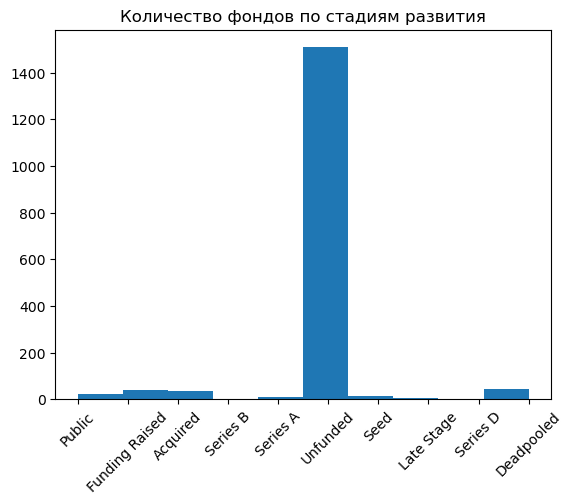

In [14]:
plt.hist(t_d['Company Stage'])
plt.title('Количество фондов по стадиям развития')
plt.xticks(rotation=45)
plt.show()

То есть, большинство фондов не профондированы и работают за счет своих денег / денег своих знакомых, что логично - это же не стартапы какие-то. Интересно отметить, что следующая по популярности категория - Deadpooled. Это фонды, которые не смогли привлечь финансирование или разорились

Теперь посмотрим на годы основания фондов с помощью такого же графика

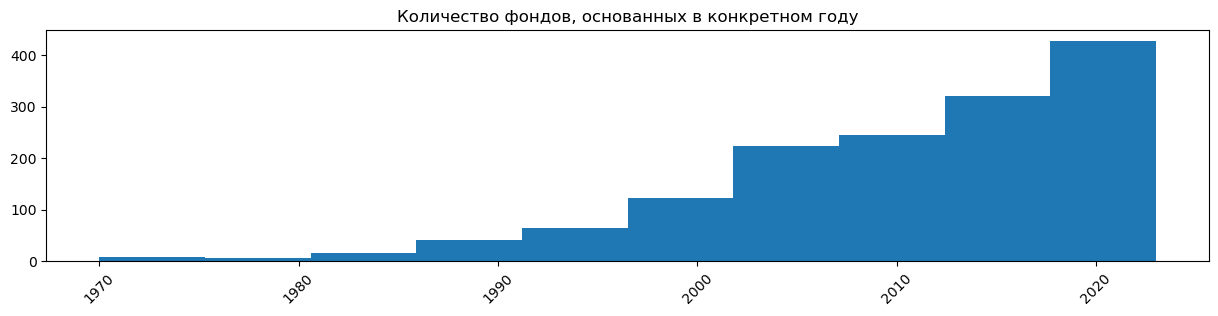

In [15]:
plt.figure(figsize=(15, 3))
plt.hist(t_d[t_d['Founded Year'] >= 1970]['Founded Year'])
plt.title('Количество фондов, основанных в конкретном году')
plt.xticks(rotation=45)
plt.show()

Интересный результат. Количество фондов постоянно растет, причем неуклонно

Среди представленных фондов особый интерес представляет Blackstone, как самый большой. Построим дерево его корпоративной структуры с помощью библиотеки для графов (source: https://lexchart.com/org-charts/blackstone-nyse-bx-company-structure/)

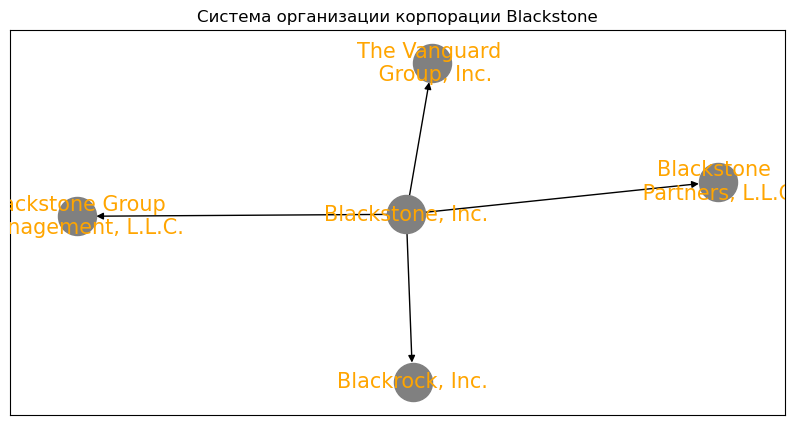

In [16]:
#Создаме граф
Blackstone_structure = nx.DiGraph()

#Создаем вершину
Blackstone_structure.add_node("Blackstone, Inc.")

#Создаем конечные вершины (листы)
Blackstone_structure.add_node("Blackstone \n Partners, L.L.C.")
Blackstone_structure.add_node("Blackstone Group \n Management, L.L.C.")
Blackstone_structure.add_node("Blackrock, Inc.")
Blackstone_structure.add_node("The Vanguard \n Group, Inc.")

#Добавляем ребра
Blackstone_structure.add_edge("Blackstone, Inc.", "Blackstone \n Partners, L.L.C.")
Blackstone_structure.add_edge("Blackstone, Inc.", "Blackstone Group \n Management, L.L.C.")
Blackstone_structure.add_edge("Blackstone, Inc.", "Blackrock, Inc.")
Blackstone_structure.add_edge("Blackstone, Inc.", "The Vanguard \n Group, Inc.")

#Показываем рисунок
plt.figure(figsize=(10,5))
nx.draw_networkx(Blackstone_structure, with_labels=True, node_color='grey', node_size=750, font_size=15, font_color='orange')
plt.title('Система организации корпорации Blackstone')
plt.show()

Не очень сложная схема, но нужно помнить, что компания интернациональная. А это значит, что конечные юр. лица разветвляются дальше

### DataSet №2

Предыдущий датасет дал нам интересную информацию, но он все же слишком общий (это и неудивительно, учитывая, откуда я его взял). Хотелось бы поподробнее посмотреть на хедж фонды, причем конкретно хедж фонды, а то ранее были представлены и компании с мултиспециализациями

In [17]:
#Здесь впишите свой путь до файла
hedgefunds_database = pd.read_csv('/Users/Alex/Desktop/hedge_funds_list.csv')

In [18]:
hedgefunds_database.head()

,Firm_Name_name,Firm_Name_City,Firm_Name_Country,Firm_Name_AUM_in_millions,Firm_Name_annual_change_in_AUM,Firm_Name_Strategies
0,AQR Capital Management,Greenwich,United States,"248,897",-0.1,"Multi Strategy, Managed Futures, Event Driven"
1,Bridgewater Associates,Westport,United States,"235,612",0.0,"Long/Short, Global Macro"
2,Citadel Investment Group,Chicago,United States,"234,679",0.2,"Convertibles, Multi Strategy"
3,Millennium Capital Partners,New York,United States,"218,000",NaN,Multi Strategy
4,Renaissance Technologies,East Setauket,United States,"165,968",0.3,"Crypto, Multi Strategy"


Это уже выглядит интереснее - тут и страны в более приятном и конкретном формате, расписаны конкретные стратегиии, что главное - есть AUMы

### Data Preparation

In [19]:
display(hedgefunds_database.dtypes)

Firm_Name_name                     object
Firm_Name_City                     object
Firm_Name_Country                  object
Firm_Name_AUM_in_millions          object
Firm_Name_annual_change_in_AUM    float64
Firm_Name_Strategies               object
dtype: object

Данные неплохи, только хотелось бы переделать AUM в формат float

In [20]:
hedgefunds_database['Firm_Name_AUM_in_millions'] = hedgefunds_database['Firm_Name_AUM_in_millions'].str.replace(',', '.').astype(float)

In [21]:
display(hedgefunds_database.dtypes)

Firm_Name_name                     object
Firm_Name_City                     object
Firm_Name_Country                  object
Firm_Name_AUM_in_millions         float64
Firm_Name_annual_change_in_AUM    float64
Firm_Name_Strategies               object
dtype: object

Теперь всё хорошо

### Data Analysis

Теперь поанализируем данные

Интересно посмотреть на капитализацию по странам. Воспользуемся функциями group, transform и тем фактом, что unique считывает данные по порядку. 

In [22]:
hedgefunds_database['Country_AUM'] = hedgefunds_database.groupby('Firm_Name_Country')['Firm_Name_AUM_in_millions'].transform('sum')
hedgefunds_database.head()

,Firm_Name_name,Firm_Name_City,Firm_Name_Country,Firm_Name_AUM_in_millions,Firm_Name_annual_change_in_AUM,Firm_Name_Strategies,Country_AUM
0,AQR Capital Management,Greenwich,United States,248.897,-0.1,"Multi Strategy, Managed Futures, Event Driven",3900.439
1,Bridgewater Associates,Westport,United States,235.612,0.0,"Long/Short, Global Macro",3900.439
2,Citadel Investment Group,Chicago,United States,234.679,0.2,"Convertibles, Multi Strategy",3900.439
3,Millennium Capital Partners,New York,United States,218.000,NaN,Multi Strategy,3900.439
4,Renaissance Technologies,East Setauket,United States,165.968,0.3,"Crypto, Multi Strategy",3900.439


In [23]:
for i, j in zip(hedgefunds_database['Firm_Name_Country'].unique(), hedgefunds_database['Country_AUM'].unique()):
    print('AUM in', i, 'is', j, 'mn$')

AUM in United States is 3900.439 mn$
AUM in United Kingdom is 428.29699999999997 mn$
AUM in France is 47.737 mn$
AUM in Hong Kong is 101.608 mn$
AUM in Switzerland is 31.715 mn$
AUM in Brazil is 28.21 mn$
AUM in Australia is 16.431 mn$
AUM in Denmark is 15.5 mn$
AUM in Sweden is 14.2 mn$


Америка далеко впереди, хотя тот факт, что в бедной Бразилии эта цифра сопоставима с богатой и процветающей Швецарией и даже превосходит Данию со Швецией - по истине интересная информация

Теперь создадим db файл с помощью sql, куда запишем самую интересную информацию о фондах - название, страну и AUM. В дальнейшем ее кто-нибудь сможет ей воспользоваться

In [27]:
# Создаем связь с SQLite базой данных
conn = sqlite3.connect('hedge_funds.db')

# Создаем объект курсор, чтобы выполнять команды
cursor = conn.cursor()

# Создаем таблицу
# !!! Если таблица не создается, то просто слегка ее переименуйте, и она появится !!!
cursor.execute('''CREATE TABLE HedgeFund
                (Fund_name TEXT, Country TEXT, AUM REAL)''')

# Заполняем таблицу данными
for i in range(len(hedgefunds_database)):

    fund_name = hedgefunds_database.iloc[i][0]
    country = hedgefunds_database.iloc[i][2]
    AUM = hedgefunds_database.iloc[i][3]
    
    # Вставляем строки в таблицу
    cursor.execute(f"INSERT INTO funds VALUES ('{fund_name}', '{country}', {AUM})")

# Коммитим изменения в базу данных
conn.commit()

# Закрываем связь
conn.close()

Готово, можно пользоваться

Теперь покажем расположение фондов на карте с помощью библиотеки geopandas. Чем больше точка - тем больше фондов находится в местности

/var/folders/9d/gc4t49ts0js05tjpd78zspl40000gp/T/ipykernel_56449/2554092622.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


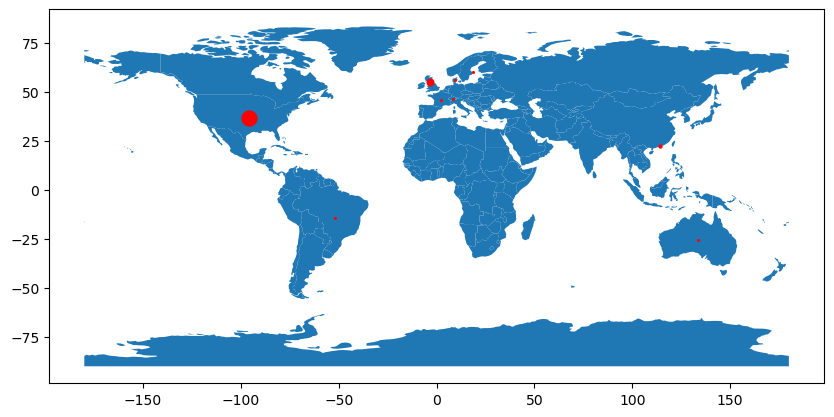

In [28]:
#Скачиваем карту мира
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#Добавляем координаты
coordinates = [('United States', (37.0902, -95.7129)), ('United Kingdom', (55.3781, -3.4360)), ('France', (46.2276, 2.2137)), ('Hong Kong', (22.3193, 114.1694)), ('Switzerland', (46.8182, 8.2275)), ('Brazil', (-14.2350, -51.9253)), ('Australia', (-25.2744, 133.7751)), ('Denmark', (56.2639, 9.5018)), ('Sweden', (60.1282, 18.6435))]

#Рисуем точки на графике
ax = world_map.plot(figsize=(10, 6))

for i in range(len(coordinates)):
    points = gpd.GeoDataFrame(geometry=gpd.points_from_xy([coordinates[i][1][1]], [coordinates[i][1][0]]))
    points.plot(ax=ax, color='red', markersize=1.5*len(hedgefunds_database[hedgefunds_database['Firm_Name_Country'] == coordinates[i][0]]))

plt.show()

В Америке хедж-фондов сильно больше, чем где-либо еще

Теперь посмотрим на типы хедж фондов. Воспользуемся beautiful soup для получения данных с проверенного сайта

In [29]:
#Указываем интересущую веб страницу
url = 'https://capital.com/hedge-fund-definiton'

#Отсылаем HTTP запрос и получаем ответ
response = requests.get(url)

#Парсим данные с помощью библиотеки
soup = BeautifulSoup(response.content, 'html.parser')

#Находим нужную секцию и парсим текст
types_of_hedge_funds = soup.find('h2', text='Types of hedge funds').find_next('ul')

#Выводим текст
for item in types_of_hedge_funds.find_all('li'):
    print(item.text)
    print()

Global macro hedge fund: These are actively-managed funds that speculate on broad market fluctuations caused by economic or political events. Fund managers may invest in company stocks, bonds, currencies, commodities, derivatives (such as futures or options contracts) and other instruments. They would analyse global fiscal and monetary policy alongside geopolitical trends to make decisions. 

Equity hedge funds: An equity fund would invest predominantly in stocks. The aim is usually to beat stock-market benchmarks, such as S&P 500 (US500) in the US, and FTSE 100 (UK100) in the UK. 

Relative value hedge fund: These types of funds rely on arbitrage, which is when you seek to generate profit from small differences in price between similar, or identical securities.

Activist hedge fund: This type of hedge fund would take an active position in the management of companies in which it invests, which means it would act as an activist shareholder of the stock. The activism tends to occur after

Из представленных фондов реалистично взглянуть на стратегии фонда 2 типа - equity hedge funds. Во всех остальных случаях тест стратегий крайне затруднителен

### Работа со стратегиями

Теперь рассмотрим популярные трейдинговые стратегии. Воспользуемся API Yahoo Finance для извлечения цен S&P500 за последние 3 года

In [30]:
df_GSPC = yf.download('^GSPC', start='2020-09-15', end='2023-06-10', progress=False)

Применим стратегию Moving Average Crossover, широко известную в трейдерских кругах. Реализуем ее с помощью библиотеки QuantLib и numpy

In [31]:
#Сет-ап
today = ql.Date.todaysDate()
ql.Settings.instance().evaluationDate = today
spot = 100
rfRate = 0.01

#Определяем дату исполнения опциона
expiration_date = ql.Date(today.dayOfMonth(), today.month(), today.year()+1)

#Определяем выплату по нему
payoff = ql.PlainVanillaPayoff(ql.Option.Call, spot)

#Определяем исполнение опциона
exercise = ql.EuropeanExercise(expiration_date)
option = ql.VanillaOption(payoff, exercise)

#Считаем цену опциона по модели Блэка-Шоулза
u = ql.SimpleQuote(spot)
r = ql.SimpleQuote(rfRate)
sigma = ql.SimpleQuote(0.20)

riskFreeCurve = ql.FlatForward(today, ql.QuoteHandle(r), ql.Actual360())
volatility = ql.BlackConstantVol(today, ql.NullCalendar(), ql.QuoteHandle(sigma), ql.Actual360())

process = ql.BlackScholesProcess(ql.QuoteHandle(u),
                                 ql.YieldTermStructureHandle(riskFreeCurve),
                                 ql.BlackVolTermStructureHandle(volatility))

option.setPricingEngine(ql.AnalyticEuropeanEngine(process))

print("Option price:", option.NPV())

#Moving average crossover strategy

#Загружаем данные
stock_data = np.array(df_GSPC['Close'])

#Определяем параметры
n_days = 5
buy_threshold = 0.02
sell_threshold = -0.02

#Считаем скользящие средние
short_ma = np.convolve(stock_data, np.ones((n_days,))/n_days, mode='valid')
long_ma = np.convolve(stock_data, np.ones((n_days*2,))/n_days, mode='valid')

#Определяемся с начальной позицией и распологаемыми средствами
position = 0
cash = 1000

#Запускаем стратегию
for i in range(n_days*2, stock_data.shape[0]):
    
    if short_ma[i-n_days*2] > long_ma[i-n_days*2] and position == 0:
        
        #Покупаем
        position = cash/stock_data[i]
        cash = 0
        print("Buy at", stock_data[i])
        
    elif short_ma[i-n_days*2] < long_ma[i-n_days*2] and position != 0:
        
        # Продаем
        cash = position*stock_data[i]
        position = 0
        print("Sell at", stock_data[i])
        
    elif (stock_data[i] - stock_data[i-1])/stock_data[i-1] > buy_threshold and position == 0:
        
        #Покупаем из-за положительного изменения цены
        position = cash/stock_data[i]
        cash = 0
        print("Buy at", stock_data[i])
        
    elif (stock_data[i] - stock_data[i-1])/stock_data[i-1] < sell_threshold and position != 0:
        
        #Продаем из-за негативного изменения цены
        cash = position*stock_data[i]
        position = 0
        print("Sell at", stock_data[i])
        
#Продаем оставшиеся акции
if position != 0:
    cash = position*stock_data[-1]
    position = 0
print("Final cash:", cash)

Option price: 8.506706813776818
Buy at 3443.43994140625
Sell at 3510.449951171875
Buy at 3901.820068359375
Sell at 3870.2900390625
Buy at 4686.75
Sell at 4701.2099609375
Buy at 4431.85009765625
Sell at 4515.5498046875
Buy at 4384.64990234375
Sell at 4373.93994140625
Buy at 4277.8798828125
Sell at 4259.52001953125
Buy at 4262.4501953125
Sell at 4357.85986328125
Buy at 4287.5
Sell at 4131.93017578125
Buy at 4300.169921875
Sell at 4146.8701171875
Buy at 4023.889892578125
Sell at 4008.010009765625
Buy at 4088.85009765625
Sell at 3923.679931640625
Buy at 4158.240234375
Sell at 4132.14990234375
Buy at 3764.7900390625
Sell at 3759.889892578125
Buy at 3911.739990234375
Sell at 3900.110107421875
Buy at 3936.68994140625
Sell at 3959.89990234375
Buy at 4023.610107421875
Sell at 4072.429931640625
Buy at 4210.240234375
Sell at 4207.27001953125
Buy at 3678.429931640625
Sell at 3790.929931640625
Buy at 3669.909912109375
Sell at 3583.070068359375
Buy at 3677.949951171875
Sell at 3719.97998046875
Buy a

Стратегия показала себя что-то не очень - в итоге мы оказались в минусе

Теперь подпредсказываем цену акций с помошью МО и библиотеки sklearn

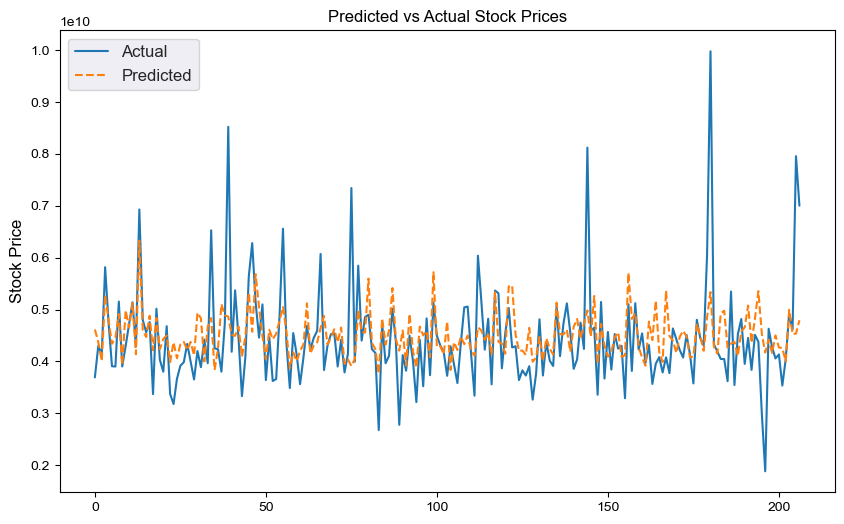

In [32]:
#Переименуем для простоты
df = df_GSPC

# Выбираем features и то, что будем предсказывать
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

#Делим данные на данные для обучения и тестирования
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Обучаем модель
model = LinearRegression()
model.fit(X_train, y_train)

#Предсказываем цену
y_pred = model.predict(X_test)

#Рисуем на графике
fig, ax = plt.subplots(figsize=(10,6))
sns.set_style('darkgrid')
ax.plot(y_test.values, label='Actual')
ax.plot(y_pred, label='Predicted', linestyle='dashed')
ax.set_title('Predicted vs Actual Stock Prices')
ax.set_ylabel('Stock Price', fontsize=12)
ax.legend(fontsize=12)
plt.show()

Предсказания получились куда менее волатильными, чем реальная цена и, кажется, не очень подходит для торговли

### Выводы

Из работы можно получить несолько интересных выводов:
    
    1. Большинство хедж фондов работают на свои деньги
    
    2. Америка - страна с самым развитым рынком хедж фондов
    
    3. Общедоступные стратегии не очень хорошо зарабатывают деньги и предсказывают будущую цену актива

P.S. Строчек кода около 130